In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

In [2]:
from utils.data_aggregator import DataAggregator
data_aggregator = DataAggregator()

In [36]:
matches = data_aggregator.get_data(["E0"], ["Date", "HomeTeam", "AwayTeam", "FTR"], ["0809", "0910", "1011", "1112", "1213", "1314", "1415", "1516", "1617", "1718", "1819", "1920", "2021", "2122", "2223", "2324"])
matches = data_aggregator.format_date(matches, "Date")
matches = data_aggregator.create_recency_variable(matches, "Date")
matches.head()

,Date,HomeTeam,AwayTeam,FTR,Year,Month,Recency
0,2008-08-16,Arsenal,West Brom,H,2008,8,0.850511
1,2008-08-16,Bolton,Stoke,H,2008,8,0.850511
2,2008-08-16,Everton,Blackburn,A,2008,8,0.850511
3,2008-08-16,Hull,Fulham,H,2008,8,0.850511
4,2008-08-16,Middlesbrough,Tottenham,H,2008,8,0.850511


In [4]:
train_matches = matches[matches["Date"] < "2023-07-01"]
test_matches = matches[matches["Date"] >= "2023-07-01"]

In [ ]:
from notebook.utils.models.ELO_model import ELORatingSystem
elo = ELORatingSystem()

In [38]:
for _, match in train_matches.iterrows():
    elo.process_match(
        home_team=match['HomeTeam'],
        away_team=match['AwayTeam'],
        full_time_result=match['FTR'],
        recency_parameter=match['Recency']
    )

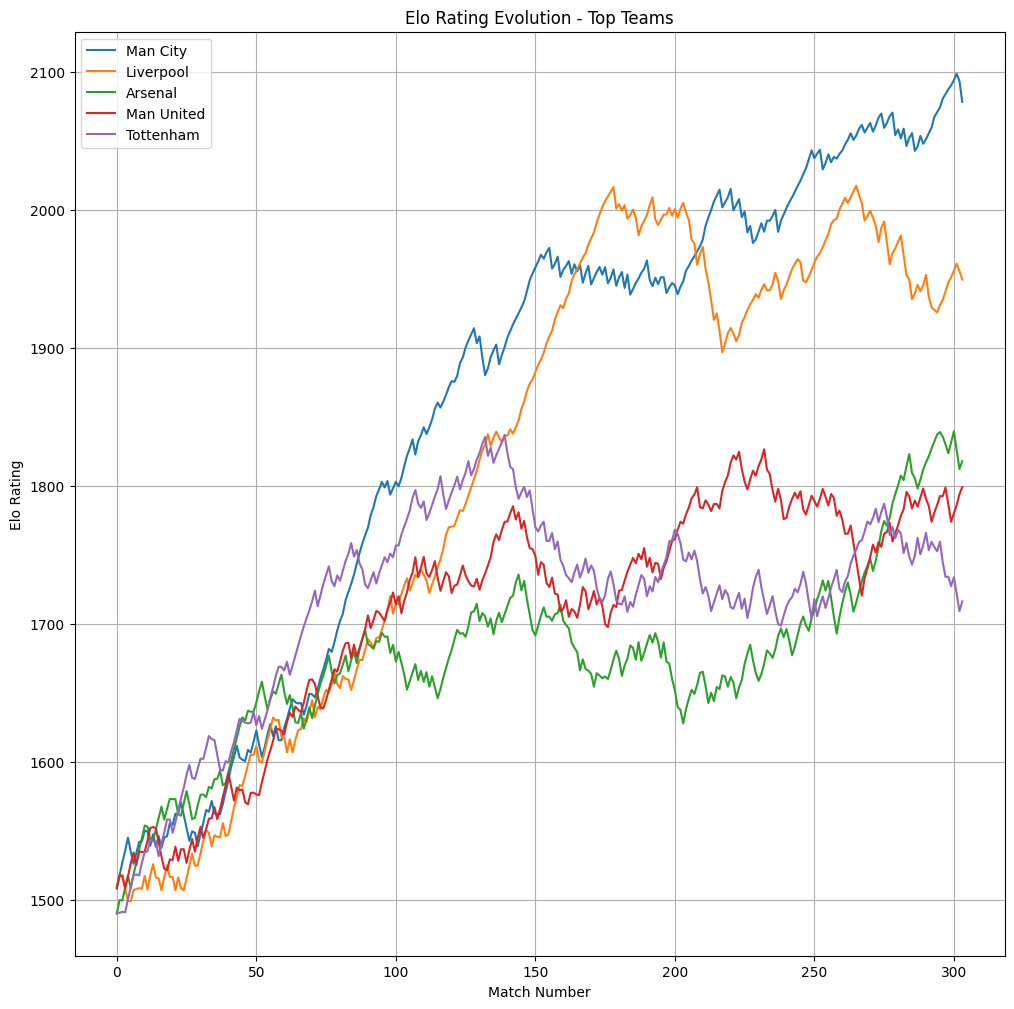

In [39]:
elo.plot_ratings()

In [44]:
league_table = elo.generate_league_table(test_matches)

In [45]:
league_table.head()

,Team,Points
0,Man City,88
1,Liverpool,78
2,Arsenal,70
3,Chelsea,58
4,Man United,55


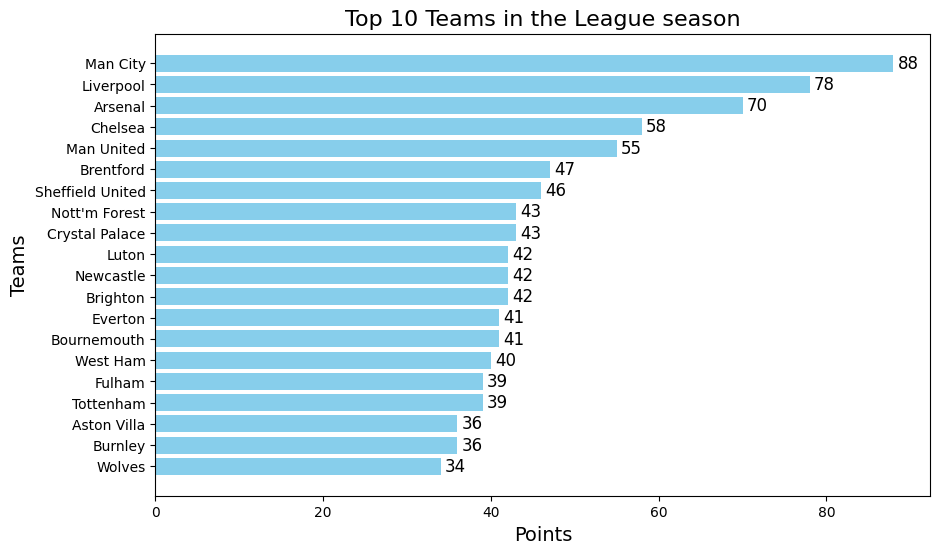

In [46]:
elo.plot_league_table(league_table, "")

In [54]:
param_grid = {
    'initial_rating': [1200, 1500, 1800],
    'alpha': [10, 20, 30],
    'normalization_constand_cdf': [200, 400, 600],
    'sharpening_factor': [0.5, 1.0, 1.5],
    'home_advantage': [0, 50, 100],
    'momentum_boost': [5, 10, 15],
    'draw_difference_requirement': [0.1, 0.2, 0.3]
}

In [12]:
# import numpy as np
# param_grid = {
#     'initial_rating': np.linspace(400, 2000, 17),
#     'alpha': np.linspace(5, 50, 21),
#     'normalization_constand_cdf': np.linspace(100, 700, 13),
#     'sharpening_factor': np.linspace(0.1, 2, 20),
#     'home_advantage': np.linspace(0, 100, 11),
#     'momentum_boost': np.linspace(0, 20, 21)
# }

In [55]:
best_params = ELORatingSystem.grid_search(train_matches, param_grid)

Coarse grid search...


100%|██████████| 2187/2187 [29:32<00:00,  1.23it/s]


Finished with coarse grid search. Current best params: {'alpha': 10, 'draw_difference_requirement': 0.1, 'home_advantage': 100, 'initial_rating': 1800, 'momentum_boost': 10, 'normalization_constand_cdf': 200, 'sharpening_factor': 0.5}
Refined grid search...


100%|██████████| 2187/2187 [29:30<00:00,  1.24it/s]

Finished with refined grid search. Best params: {'alpha': 10, 'draw_difference_requirement': 0.1, 'home_advantage': 125, 'initial_rating': 1800, 'momentum_boost': 10, 'normalization_constand_cdf': 100, 'sharpening_factor': 0.5}


In [ ]:
# best_coarse_params = {
#     'initial_rating': [1200],
#     'alpha': [10],
#     'normalization_constand_cdf': [200],
#     'sharpening_factor': [0.5],
#     'home_advantage': [100],
#     'momentum_boost': [5],
#     'draw_difference_requirement': [0.05]
# }

In [15]:
# best_fine_params = {
#     'initial_rating': 1100,
#     'alpha': 5,
#     'normalization_constand_cdf': 500,
#     'sharpening_factor': 1.25,
#     'home_advantage': 125,
#     'momentum_boost': 0
# }

In [56]:
optimized_elo = ELORatingSystem(
    initial_rating=best_params['initial_rating'],
    alpha=best_params['alpha'],
    normalization_constand_cdf=best_params['normalization_constand_cdf'],
    sharpening_factor=best_params['sharpening_factor'],
    home_advantage=best_params['home_advantage'],
    momentum_boost=best_params['momentum_boost'],
    draw_difference_requirement=best_params['draw_difference_requirement']
)

In [57]:
for _, match in train_matches.iterrows():
    optimized_elo.process_match(
        home_team=match['HomeTeam'],
        away_team=match['AwayTeam'],
        full_time_result=match['FTR'],
        recency_parameter=match['Recency']
    )

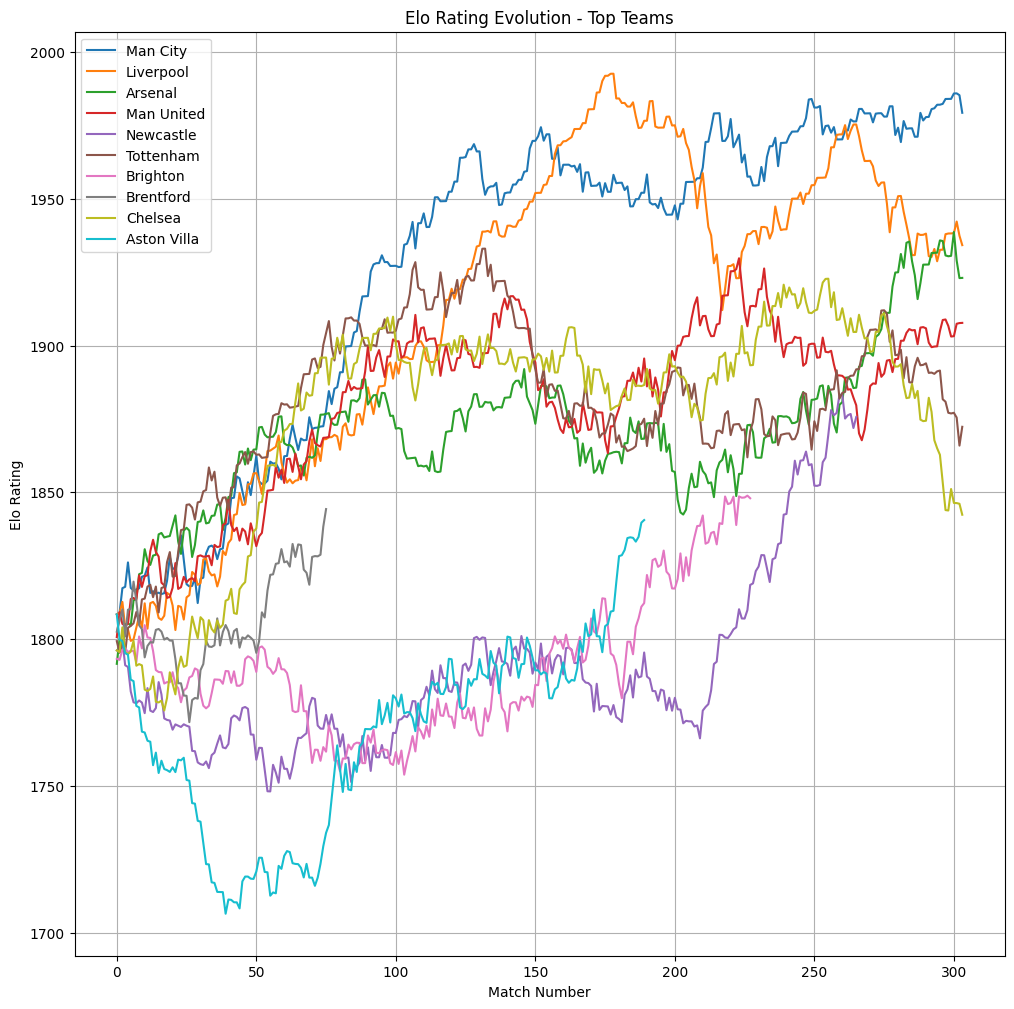

In [58]:
optimized_elo.plot_ratings(10);

In [69]:
league_table = optimized_elo.generate_league_table(test_matches)

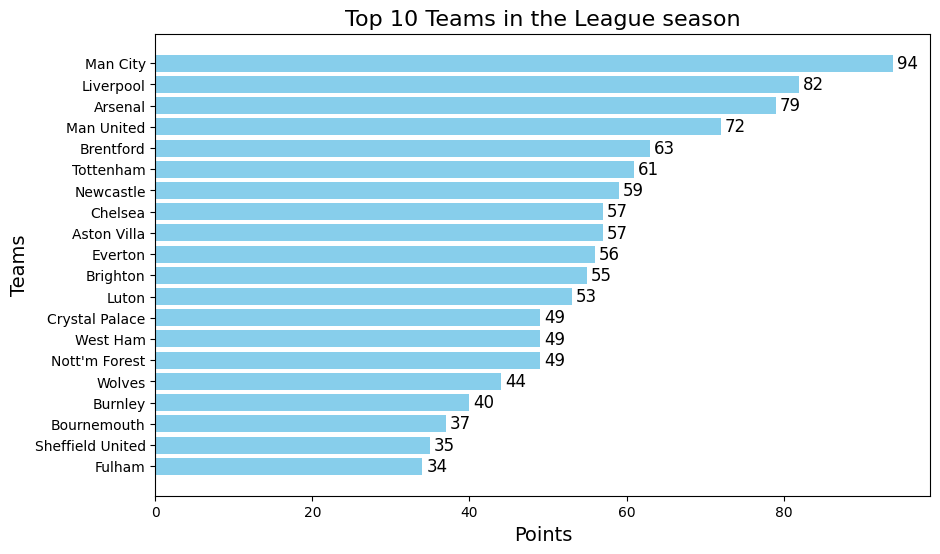

In [70]:
optimized_elo.plot_league_table(league_table, "")